---最終データセットの上から５行---
         年月日   天気    売り上げ
0 2020-01-01    雨  125027
1 2020-01-02  くもり  125891
2 2020-01-03  くもり  120933
3 2020-01-04  くもり  129119
4 2020-01-05  くもり  144672

--- 売上統計情報 ---
count      1825.000000
mean     149784.043288
std       19418.931552
min      100458.000000
25%      136331.000000
50%      148265.000000
75%      162401.000000
max      219639.000000
Name: 売り上げ, dtype: float64

--- 月ごとの平均天気日数（5年平均） ---
天気  くもり  晴れ  雨
月             
1    11  17  3
2    13  11  4
3    10  20  2
4    10  18  2
5    11  18  2
6    14  10  6
7     8  20  4
8     9  21  1
9    16   7  7
10   13  16  3
11   12  17  2
12   16  10  4


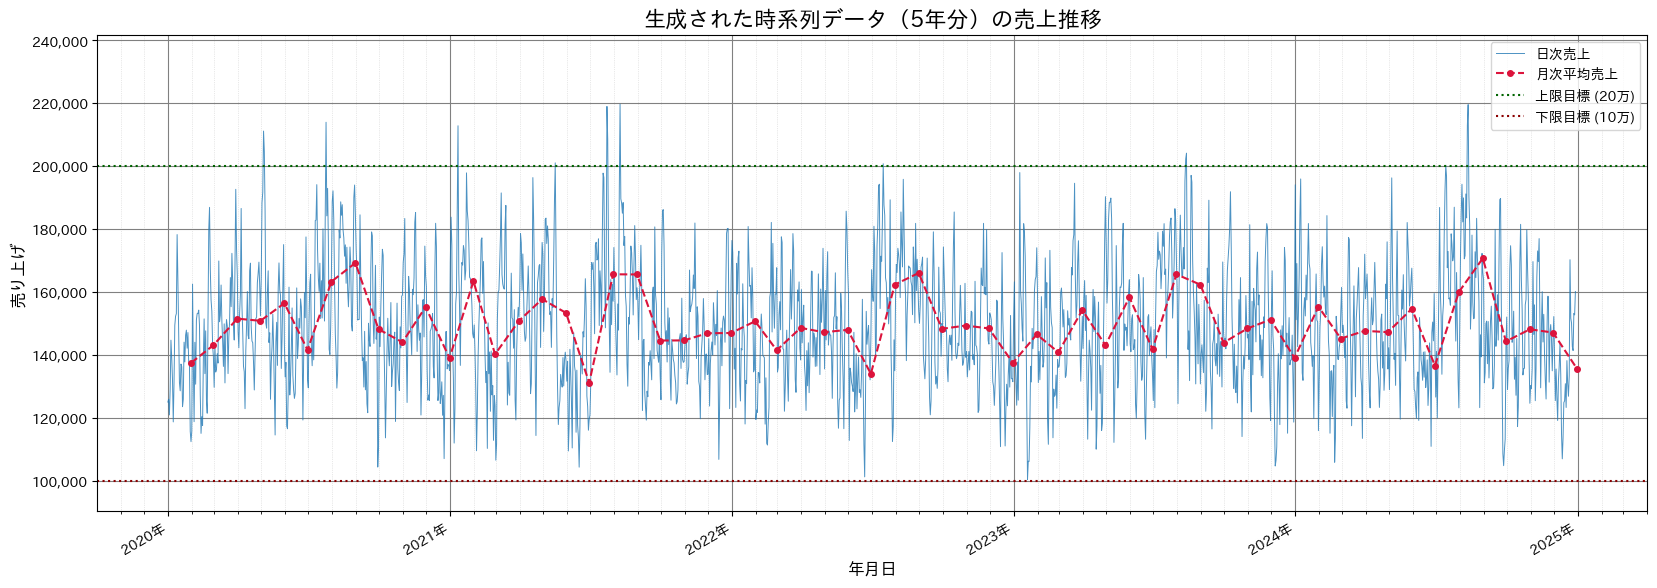

In [27]:
import pandas as pd
import numpy as np
import datetime
import jpholiday
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib

# 乱数シードを固定して、毎回同じ結果になるようにする
np.random.seed(123)

# 1. パラメータ設定
# ==========================================================================
# --- 基本設定 ---
YEARS = 5
start_date = datetime.date(2020, 1, 1)

# ★★★★★【変更点①】季節ごとの遷移行列を定義 ★★★★★
# --- 天気関連 ---
# 季節ごとに異なる天気のルール（遷移行列）を定義
transition_matrices = {
    # --- 通常期 (春・秋) ---
    'normal': pd.DataFrame({
        # 明日の天気
        '晴れ': {'晴れ': 0.70, 'くもり': 0.25, '雨': 0.05},  # 今日の天気
        'くもり': {'晴れ': 0.40, 'くもり': 0.50, '雨': 0.10},
        '雨':   {'晴れ': 0.45, 'くもり': 0.45, '雨': 0.10}
    }).T,
    # --- 梅雨/秋雨期 (雨が多め) ---
    'rainy_season': pd.DataFrame({
        '晴れ': {'晴れ': 0.50, 'くもり': 0.40, '雨': 0.10},  # 晴れが続きにくい
        'くもり': {'晴れ': 0.20, 'くもり': 0.50, '雨': 0.30},
        '雨':   {'晴れ': 0.20, 'くもり': 0.50, '雨': 0.30}   # 雨や曇りが続きやすい
    }).T,
    # --- 夏期 (晴れが多いが、天気は変わりやすい) ---
    'summer': pd.DataFrame({
        '晴れ': {'晴れ': 0.80, 'くもり': 0.15, '雨': 0.05},  # 晴れが非常に続きやすい
        'くもり': {'晴れ': 0.50, 'くもり': 0.35, '雨': 0.15},  # 曇っても晴れやすい
        '雨':   {'晴れ': 0.40, 'くもり': 0.40, '雨': 0.20}   # 雨は長続きしにくい
    }).T,
    # --- 冬期 (晴れも多いが、曇りもそこそこ) ---
    'winter': pd.DataFrame({
        '晴れ': {'晴れ': 0.65, 'くもり': 0.30, '雨': 0.05},
        'くもり': {'晴れ': 0.30, 'くもり': 0.50, '雨': 0.20},
        '雨':   {'晴れ': 0.25, 'くもり': 0.50, '雨': 0.25}
    }).T
}

# 月と季節パターンを対応付ける辞書
month_to_season_map = {
    1: 'winter', 2: 'winter',
    3: 'normal', 4: 'normal', 5: 'normal',
    6: 'rainy_season', # 梅雨
    7: 'summer', 8: 'summer',
    9: 'rainy_season', # 秋雨
    10: 'normal', 11: 'normal',
    12: 'winter'
}


# --- 売上関連 (変更なし) ---
sales_stats = {
    '晴れ': {'mean': 150000, 'std': 10000},
    'くもり': {'mean': 125000, 'std': 8000},
    '雨':   {'mean': 100000, 'std': 7000}
}
seasonal_factors = {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1., 6: 1., 7: 1.1, 8: 1.1, 9: 1.05, 10: 1.0, 11: 1.0, 12: 1.0}
weekday_factors = {0: 1.1, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.1, 5: 1.15, 6: 1.15}
event_days = {date: 1.25 for date, name in jpholiday.between(start_date, start_date + datetime.timedelta(days=365*YEARS))}
autocorrelation_alpha = 0.5
# ==========================================================================


# 2. データフレームの準備と天気データの生成
# ★★★★★【変更点②】月ごとの遷移行列を使って天気を生成 ★★★★★
# ==========================================================================
days = 365 * YEARS
dates = pd.date_range(start_date, periods=days, freq='D')
df = pd.DataFrame({'年月日': dates})
months = df['年月日'].dt.month # 事前に月のリストを作成

weathers = []
# どの季節の行列でも状態は同じなので 'normal' から取得
weather_states = list(transition_matrices['normal'].index)

# 初日の天気をランダムに決定
current_weather = np.random.choice(weather_states)
weathers.append(current_weather)

# 2日目以降の天気を、月ごとのルールに基づいて生成
for i in range(1, len(df)):
    # 今日の月を取得
    current_month = months[i-1]
    # 月に対応する季節を取得
    season = month_to_season_map[current_month]
    # 季節に対応する遷移行列を選択
    current_transition_matrix = transition_matrices[season]

    # 選択した遷移行列を使って次の日の天気を決定
    transition_probabilities = current_transition_matrix.loc[current_weather]
    next_weather = np.random.choice(
        transition_probabilities.index,
        p=transition_probabilities.values
    )
    weathers.append(next_weather)
    # 現在の天気を更新
    current_weather = next_weather

df['天気'] = weathers
# ==========================================================================


# 3. 売上データの生成ループ (変更なし)
# ==========================================================================
sales = []
weekdays = df['年月日'].dt.weekday
dates_for_event_check = df['年月日'].dt.date
base_mean_day1 = sales_stats[weathers[0]]['mean']
expected_sale_day1 = base_mean_day1 * seasonal_factors[months[0]] * weekday_factors[weekdays[0]]
if dates_for_event_check[0] in event_days:
    expected_sale_day1 *= event_days[dates_for_event_check[0]]
target_day1 = expected_sale_day1
std_dev_day1 = sales_stats[weathers[0]]['std']
final_sale_day1 = max(0, int(np.random.normal(loc=target_day1, scale=std_dev_day1)))
sales.append(final_sale_day1)
previous_sale = final_sale_day1

for i in range(1, len(df)):
    weather = weathers[i]
    month = months[i]
    weekday = weekdays[i]
    date = dates_for_event_check[i]
    base_mean = sales_stats[weather]['mean']
    expected_sale = base_mean * seasonal_factors[month] * weekday_factors[weekday]
    if date in event_days:
        expected_sale *= event_days[date]
    correlated_sale_target = (1 - autocorrelation_alpha) * expected_sale + autocorrelation_alpha * previous_sale
    std_dev = sales_stats[weather]['std']
    final_sale = max(0, int(np.random.normal(loc=correlated_sale_target, scale=std_dev)))
    sales.append(final_sale)
    previous_sale = final_sale

df['売り上げ'] = sales
# ==========================================================================


# 4. 生成されたデータの確認
# ★★★★★【変更点③】月ごとの天気日数を集計して確認 ★★★★★
# ==========================================================================
print("---最終データセットの上から５行---")
print(df.head())
print("\n--- 売上統計情報 ---")
print(df['売り上げ'].describe())

# ★★★★★【ここを修正】必ず1月～12月まで表示されるように変更 ★★★★★
print("\n--- 月ごとの平均天気日数（5年平均） ---")
# 月ごとに天気の出現回数をカウント
monthly_weather_counts = df.groupby(df['年月日'].dt.month)['天気'].value_counts().unstack(fill_value=0)

# 1月から12月までのインデックスを作成
all_months_index = pd.Index(range(1, 13), name='月')
# 作成したインデックスで集計結果を再構成し、データがない月は0で埋める
monthly_weather_counts_all = monthly_weather_counts.reindex(all_months_index, fill_value=0)

# 年数で割って平均を出し、整数に丸めて表示
print(round(monthly_weather_counts_all / YEARS).astype(int))



# グラフ描画 (変更なし)
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(df['年月日'], df['売り上げ'], linewidth=0.7, alpha=0.8, label='日次売上')
monthly_avg = df.set_index('年月日')['売り上げ'].resample('ME').mean()
ax.plot(monthly_avg.index, monthly_avg.values, linestyle='--', marker='o', markersize=4, color='crimson', label='月次平均売上')
ax.axhline(y=200000, color='darkgreen', linestyle=':', linewidth=1.5, label='上限目標 (20万)')
ax.axhline(y=100000, color='darkred', linestyle=':', linewidth=1.5, label='下限目標 (10万)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y年'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_title('生成された時系列データ（5年分）の売上推移', fontsize=16)
ax.set_ylabel('売り上げ', fontsize=12)
ax.set_xlabel('年月日', fontsize=12)
ax.legend()
ax.grid(True, which='major', linestyle='-', linewidth='0.8', color='gray')
ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
fig.autofmt_xdate()
min_sale = df['売り上げ'].min()
max_sale = df['売り上げ'].max()
ax.set_ylim(min_sale * 0.9, max_sale * 1.1)

plt.show()
# ==========================================================================